#Opening pizza restaurant in Helsinki



This project results will be interesting for who are wanting to open pizza restaurant in Helsinki and wants to know in which neighbourhood there is greater chance to succeed taking into account existing market and competition.

Notice also that model used for making assessment for Helsinki area can be also used with small modification also for other municipalities in Finland and venue type can be changed as well (i.e. Japanese restaurants).


Data used in analysis:

Data for the project will acquired from freely available sources – the following datasets will be used:
1.	Finland’s national statistical data on neighbourhood level. This data will include following datasets on post index (neighbourhood) level:
a.	Area: how large post index area is.
b.	Number of people working in selected area.
c.	Total population.
d.	Adult population (over 18 years old population).
e.	Average income per inhabitant 
f.	Median income per inhabitant
g.	Number of households
h.	Average size of households
i.	Average income per household
j.	Median income per household
2.	Finnish neighbourhoods’ geolocation data.
3.	Pizza restaurants’ location data.






# 1. Preparing the data

##1.1. Retrieving Finland's statistical data.

Installing all the necessary libraries


In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


Importing statistical data for Finland from Github. Extract is combined from following sources:

Finnish statistics: www.stat.fi

Geolocations: https://www.avoindata.fi/data/fi/dataset/postcodes

In [2]:
url = 'https://raw.githubusercontent.com/RomanLub/IBM-Capstone-project/main/Data_input.csv'
finland_df = pd.read_csv('https://raw.githubusercontent.com/RomanLub/IBM-Capstone-project/main/Data_input.csv')

Making sure data is looking right.

In [3]:
# take a look at the dataset
finland_df.head(5)

,Postal Code,Municipality,Neighborhood,Latitude,Longitude,Area,Job_places,Population,Adult_population,Average_income_inhabitant,Median_income_inhabitant,Households_total,Average_size_household,Average_income_household,Median_income_household
0,100,Helsinki,Helsinki Keskusta - Etu-Töölö,60.172750,24.931433,2353278,48470,18284,15935,38985,26642,10205,1.8,61679,38895
1,120,Helsinki,Punavuori,60.163221,24.939136,414010,8358,7108,6116,39248,27133,3933,1.8,61960,41377
2,130,Helsinki,Kaartinkaupunki,60.164546,24.948652,428960,11138,1508,1322,49622,28655,818,1.8,80342,45999
3,140,Helsinki,Kaivopuisto - Ullanlinna,60.157768,24.952482,931841,2347,7865,6866,48293,28115,4404,1.8,75267,41795
4,150,Helsinki,Eira - Hernesaari,60.157045,24.936956,1367328,5336,9496,8466,37054,25885,5759,1.6,54193,34512


In [4]:
finland_df.shape

(3025, 15)

Removing neighborhoods with no coordinates (notice only two neighborhoods do not have coordinates).

In [5]:
finland_df.dropna(subset = ['Longitude'], inplace=True)
finland_df.shape

(3023, 15)

Removing other municipalities except Helsinki (municipality can be changed afterwards).

In [6]:
mun_df = finland_df[finland_df['Municipality'] == 'Helsinki']
mun_df.shape

(84, 15)

Making sure data is in a right format.

In [7]:
mun_df.dtypes

Postal Code                    int64
Municipality                  object
Neighborhood                  object
Latitude                     float64
Longitude                    float64
Area                           int64
Job_places                     int64
Population                     int64
Adult_population               int64
Average_income_inhabitant      int64
Median_income_inhabitant       int64
Households_total               int64
Average_size_household       float64
Average_income_household       int64
Median_income_household        int64
dtype: object

##1.2. Retrieving FourSquare data

Define Foursquare Credentials and Version

In [8]:
CLIENT_ID = 'PMRQBV51OU1R3PMGWHRKQP25ZIDD4DHB3IYVMPFBAJ4KRUKH' # your Foursquare ID
#CLIENT_ID = 'BKN30AZEP33DMSLNJQWWIYFVUGVQW45ATYGYWY5OBBF3EQZY' #secondary
CLIENT_SECRET = 'A1UC0MCKUGQ14M21XLIEJEY20XG4RJWBQDXZRBSSZR1E1FNJ' # your Foursquare Secret
#CLIENT_SECRET = 'THYD2BKD4G15THBBDOD11WGXGDPABJM331T4T4IJ52WOTCCS' # secondary
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: PMRQBV51OU1R3PMGWHRKQP25ZIDD4DHB3IYVMPFBAJ4KRUKH
CLIENT_SECRET:A1UC0MCKUGQ14M21XLIEJEY20XG4RJWBQDXZRBSSZR1E1FNJ


Defining a function to fetch venues around a given neighborhood

In [9]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Running above function on each neighborhood and create a new dataframe called _hel_venues_.

In [10]:
mun_venues = getNearbyVenues(names=mun_df['Neighborhood'],
                                   latitudes=mun_df['Latitude'],
                                   longitudes=mun_df['Longitude']
                                  )

Helsinki Keskusta - Etu-Töölö
Punavuori
Kaartinkaupunki
Kaivopuisto - Ullanlinna
Eira - Hernesaari
Katajanokka
Kruununhaka
Kamppi - Ruoholahti
Suomenlinna
Lauttasaari
Vattuniemi
Jätkäsaari
Ilmala
Länsi-Pasila
Taka-Töölö
Keski-Töölö
Pohjois-Meilahti
Ruskeasuo
Meilahden sairaala-alue
Pikku Huopalahti
Kivihaka
Etelä-Haaga
Munkkiniemi
Kuusisaari-Lehtisaari
Munkkivuori-Niemenmäki
Pajamäki
Reimarla
Pitäjänmäen teollisuusalue
Konala
Pohjois-Haaga
Malminkartano
Kannelmäki
Maununneva
Lassila
Sörnäinen
Etu-Vallila - Alppila
Itä-Pasila
Kallio
Kalasatama
Vallila
Toukola-Vanhakaupunki
Kulosaari
Verkkosaari
Kaitalahti
Koskela-Helsinki
Käpylä
Metsälä-Etelä-Oulunkylä
Maunula-Suursuo
Oulunkylä-Patola
Veräjämäki
Länsi-Pakila
Paloheinä
Itä-Pakila
Tuomarinkylä-Torpparinmäki
Malmi
Pihlajamäki
Pukinmäki-Savela
Tapanila
Siltamäki
Puistola
Suurmetsä
Jakomäki - Alppikylä
Tapaninvainio
Viikki
Länsi-Herttoniemi
Herttoniemi
Roihuvuori
Tammisalo
Laajasalo
Jollas
Santahamina
Etelä-Laajasalo
Roihupellon teollisuusal

Incpecting results.

In [11]:
print(mun_venues.shape)
mun_venues.head(5)

(1650, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Helsinki Keskusta - Etu-Töölö,60.17275,24.931433,Taidehalli,60.172127,24.931014,Art Gallery
1,Helsinki Keskusta - Etu-Töölö,60.17275,24.931433,Arkadia Oy International Bookshop,60.173369,24.929330,Bookstore
2,Helsinki Keskusta - Etu-Töölö,60.17275,24.931433,Luonnontieteellinen museo,60.171350,24.931549,Science Museum
3,Helsinki Keskusta - Etu-Töölö,60.17275,24.931433,Ateljé Finne,60.171198,24.928515,Scandinavian Restaurant
4,Helsinki Keskusta - Etu-Töölö,60.17275,24.931433,Musiikkitalo,60.173424,24.934031,Concert Hall


Removing unnecesarry columns from progect point of view (venue's name and coordinates).

In [12]:
mun_venues = mun_venues.drop(['Venue','Venue Latitude','Venue Longitude'], axis=1)
mun_venues.head(5)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue Category
0,Helsinki Keskusta - Etu-Töölö,60.17275,24.931433,Art Gallery
1,Helsinki Keskusta - Etu-Töölö,60.17275,24.931433,Bookstore
2,Helsinki Keskusta - Etu-Töölö,60.17275,24.931433,Science Museum
3,Helsinki Keskusta - Etu-Töölö,60.17275,24.931433,Scandinavian Restaurant
4,Helsinki Keskusta - Etu-Töölö,60.17275,24.931433,Concert Hall


Creating df where all venues are summed up on neighborhood level.

In [13]:
mun_venues=mun_venues.groupby('Neighborhood')['Venue Category'].value_counts().unstack().fillna(0)
print(mun_venues.shape) #notice number of neighborhoods is 83 in Finnish statistical data 84
mun_venues.head(5)

(84, 258)


Venue Category,ATM,African Restaurant,American Restaurant,Antique Shop,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Automotive Shop,BBQ Joint,Badminton Court,Bagel Shop,Bakery,Bar,Basketball Court,Beach,Beer Bar,Beer Garden,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Buffet,Burger Joint,Burrito Place,Bus Station,Bus Stop,Butcher,Cable Car,Cafeteria,Café,Canal,Candy Store,Castle,Caucasian Restaurant,Cheese Shop,Chinese Restaurant,Circus School,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Roaster,Coffee Shop,College Cafeteria,College Science Building,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Costume Shop,Cultural Center,Curling Ice,Dance Studio,Daycare,Deli / Bodega,Department Store,Dessert Shop,Diner,Disc Golf,Discount Store,Distillery,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Film Studio,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Football Stadium,Forest,French Restaurant,Furniture / Home Store,Garden,Garden Center,Gastropub,Gay Bar,German Restaurant,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Hill,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hockey Rink,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Indoor Play Area,Intersection,Irish Pub,Island,Italian Restaurant,Japanese Restaurant,Jazz Club,Karaoke Bar,Kebab Restaurant,Kitchen Supply Store,Korean Restaurant,Kurdish Restaurant,Lake,Library,Liquor Store,Lounge,Malay Restaurant,Martial Arts School,Massage Studio,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Mobility Store,Modern European Restaurant,Monument / Landmark,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,Nightclub,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Outdoor Supply Store,Paper / Office Supplies Store,Park,Pastry Shop,Pet Store,Pharmacy,Piano Bar,Pier,Pizza Place,Platform,Playground,Plaza,Pool,Pool Hall,Port,Post Office,Print Shop,Pub,Racetrack,Record Shop,Recording Studio,Recreation Center,Restaurant,Road,Rock Club,Roof Deck,Russian Restaurant,Sandwich Place,Sauna / Steam Room,Scandinavian Restaurant,Scenic Lookout,Science Museum,Seafood Restaurant,Shoe Store,Shop & Service,Shopping Mall,Skate Park,Skating Rink,Ski Trail,Snack Place,Soccer Field,Soccer Stadium,Soup Place,South American Restaurant,Souvenir Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Club,Steakhouse,Supermarket,Sushi Restaurant,Taco Place,Tapas Restaurant,Tattoo Parlor,Taxi Stand,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park Ride / Attraction,Theme Restaurant,Thrift / Vintage Store,Tibetan Restaurant,Tourist Information Center,Toy / Game Store,Track,Trail,Train Station,Tram Station,Turkish Restaurant,Used Bookstore,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Video Store,Vietnamese Restaurant,Warehouse Store,Waterfront,Wine Bar,Wine Shop,Wings Joint,Yoga Studio,Zoo
Neighborhood,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Aurinkolahti,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1

In [14]:
mun_venues.sum(axis=0)


Venue Category
ATM                                2.0
African Restaurant                 1.0
American Restaurant                1.0
Antique Shop                       2.0
Art Gallery                       13.0
Art Museum                         5.0
Arts & Crafts Store                1.0
Asian Restaurant                   7.0
Athletics & Sports                 2.0
Auditorium                         1.0
Automotive Shop                    1.0
BBQ Joint                          1.0
Badminton Court                    1.0
Bagel Shop                         1.0
Bakery                            23.0
Bar                               52.0
Basketball Court                   2.0
Beach                              4.0
Beer Bar                          24.0
Beer Garden                        4.0
Bike Shop                          1.0
Bistro                            10.0
Board Shop                         1.0
Boat or Ferry                     13.0
Bookstore                          2.0
Boutique  

##1.3. Combine statistical and venue data, plus setting venue for analysis

Merging to data sets and naming a_df for sake of simplicit.

In [15]:
a_df = pd.merge(left=finland_df, right=mun_venues, left_on='Neighborhood', right_on='Neighborhood')
print(a_df.shape)
a_df.head(5)

(84, 273)


,Postal Code,Municipality,Neighborhood,Latitude,Longitude,Area,Job_places,Population,Adult_population,Average_income_inhabitant,Median_income_inhabitant,Households_total,Average_size_household,Average_income_household,Median_income_household,ATM,African Restaurant,American Restaurant,Antique Shop,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Automotive Shop,BBQ Joint,Badminton Court,Bagel Shop,Bakery,Bar,Basketball Court,Beach,Beer Bar,Beer Garden,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Buffet,Burger Joint,Burrito Place,Bus Station,Bus Stop,Butcher,Cable Car,Cafeteria,Café,Canal,Candy Store,Castle,Caucasian Restaurant,Cheese Shop,Chinese Restaurant,Circus School,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Roaster,Coffee Shop,College Cafeteria,College Science Building,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Costume Shop,Cultural Center,Curling Ice,Dance Studio,Daycare,Deli / Bodega,Department Store,Dessert Shop,Diner,Disc Golf,Discount Store,Distillery,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Film Studio,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Football Stadium,Forest,French Restaurant,Furniture / Home Store,Garden,Garden Center,Gastropub,Gay Bar,German Restaurant,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Hill,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hockey Rink,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Indoor Play Area,Intersection,Irish Pub,Island,Italian Restaurant,Japanese Restaurant,Jazz Club,Karaoke Bar,Kebab Restaurant,Kitchen Supply Store,Korean Restaurant,Kurdish Restaurant,Lake,Library,Liquor Store,Lounge,Malay Restaurant,Martial Arts School,Massage Studio,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Mobility Store,Modern European Restaurant,Monument / Landmark,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,Nightclub,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Outdoor Supply Store,Paper / Office Supplies Store,Park,Pastry Shop,Pet Store,Pharmacy,Piano Bar,Pier,Pizza Place,Platform,Playground,Plaza,Pool,Pool Hall,Port,Post Office,Print Shop,Pub,Racetrack,Record Shop,Recording Studio,Recreation Center,Restaurant,Road,Rock Club,Roof Deck,Russian Restaurant,Sandwich Place,Sauna / Steam Room,Scandinavian Restaurant,Scenic Lookout,Science Museum,Seafood Restaurant,Shoe Store,Shop & Service,Shopping Mall,Skate Park,Skating Rink,Ski Trail,Snack Place,Soccer Field,Soccer Stadium,Soup Place,South American Restaurant,Souvenir Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Club,Steakhouse,Supermarket,Sushi Restaurant,Taco Place,Tapas Restaurant,Tattoo Parlor,Taxi Stand,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park Ride / Attraction,Theme Restaurant,Thrift / Vintage Store,Tibetan Restaurant,Tourist Information Center,Toy / Game Store,Track,Trail,Train Station,Tram Station,Turkish Restaurant,Used Bookstore,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Video Store,Vietnamese Restaurant,Warehouse Store,Waterfront,Wine Bar,Wine Shop,Wings Joint,Yoga Studio,Zoo
0,100,Helsinki,Helsinki Keskusta - Etu-Töölö,60.172750,24.931433,2353278,48470,18284,15935,38985,26642,10205,1.8,61679,38895,0.0,0.0,0.0,0.0,1.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0

**Selecting venue for analysis. If other type of venue wanted to be analayzed - change it here. Notice also that if venue is changed, set of independet variables for the model might change as weel (check part 2.).**

In [16]:
venue ='Pizza Place'#Venue can be changed here to any other

#2. Creating recommendations model for selecting neighborhood in which selected venue can be potentially opened.

##2.1. Selecting parameters for algorithms

Creating separate dataframe for selected venue to analyze independent and dependent variables.

In [17]:
selected_df=a_df[['Area','Job_places', 'Population', 'Adult_population','Average_income_inhabitant','Median_income_inhabitant','Households_total','Average_size_household','Average_income_household','Median_income_household',venue]]
selected_df.head(5)

,Area,Job_places,Population,Adult_population,Average_income_inhabitant,Median_income_inhabitant,Households_total,Average_size_household,Average_income_household,Median_income_household,Pizza Place
0,2353278,48470,18284,15935,38985,26642,10205,1.8,61679,38895,0.0
1,414010,8358,7108,6116,39248,27133,3933,1.8,61960,41377,4.0
2,428960,11138,1508,1322,49622,28655,818,1.8,80342,45999,3.0
3,931841,2347,7865,6866,48293,28115,4404,1.8,75267,41795,1.0
4,1367328,5336,9496,8466,37054,25885,5759,1.6,54193,34512,1.0


Visualizing interrelations between independet and dependet variables.

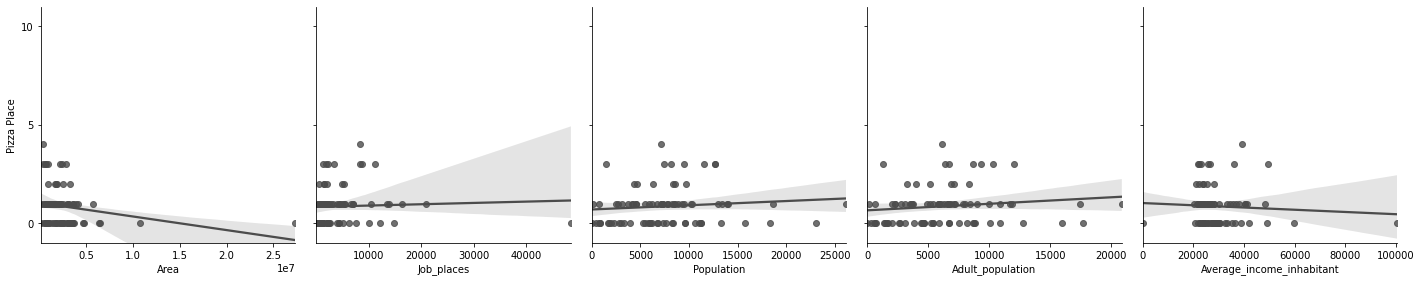

In [57]:
import seaborn as sns #package for plots
g = sns.PairGrid(selected_df, y_vars=[venue], x_vars=['Area','Job_places', 'Population', 'Adult_population','Average_income_inhabitant'], height=4)
g.map(sns.regplot, color=".3")
g.set(ylim=(-1, 11), yticks=[0, 5, 10])

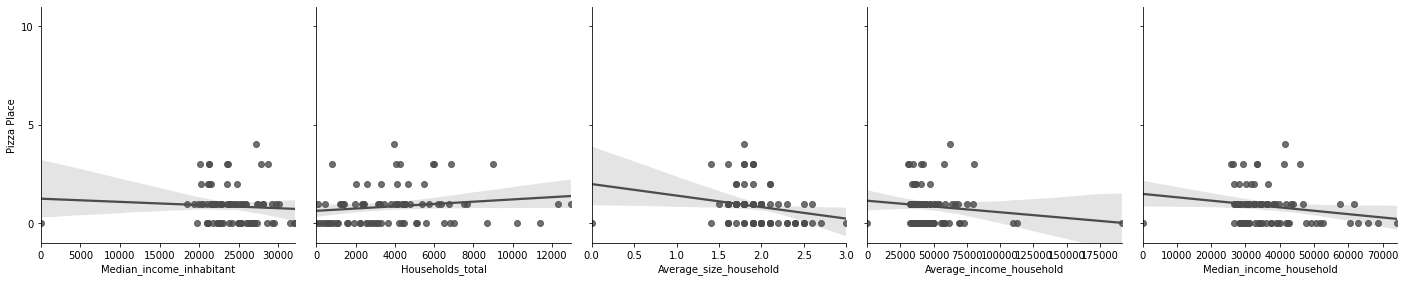

In [58]:
g = sns.PairGrid(selected_df, y_vars=[venue], x_vars=['Median_income_inhabitant','Households_total','Average_size_household','Average_income_household','Median_income_household'], height=4)
g.map(sns.regplot, color=".3")
g.set(ylim=(-1, 11), yticks=[0, 5, 10])

Comment: no strong correlations visible between dependent and independent variables.

Creating correlation matrix just to be sure.

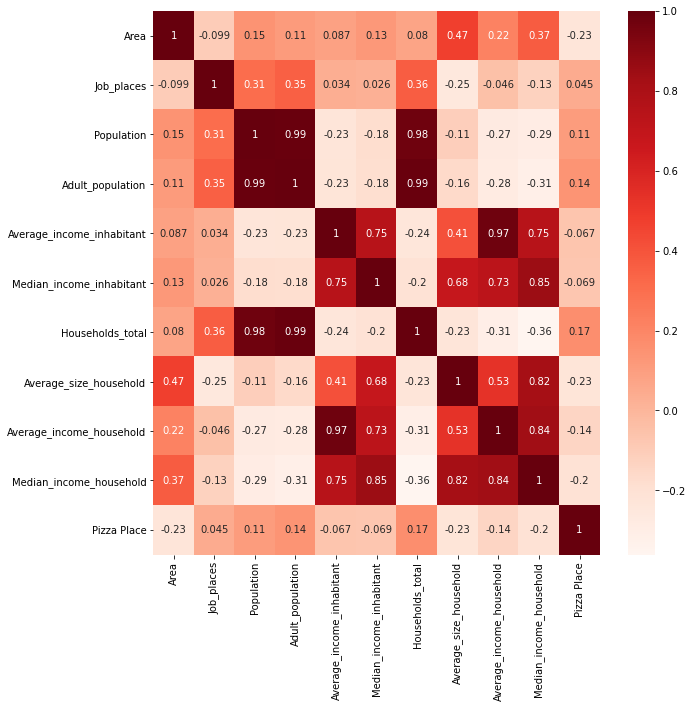

In [19]:
import matplotlib.pyplot as plt
corrMatrix = selected_df.corr()
fig, ax = plt.subplots(figsize=(10,10))  
sns.heatmap(corrMatrix, annot=True,cmap=plt.cm.Reds)
plt.show()

No strong correlations found. For now we will use filttering method to select features which have most predictive power and at the same time do not strongly correlate which each other --> removing multicollinearity problem (i.e. Population and Adult_populatio). Selelcted features will be:

1.   Area
2. Job_places (though having low correlation - feature will be added to improve slightly estimations)
3.   Households_total (by selecting this feature we will need to exclude Population and Adult_population)
4. Average_size_of_household
5. Median_income_of_household. 

These parameters will be used in SVM, KNN and logistic regression models as they are all prone to multicollinearity

For decision tree model we will use all selected values thus decision trees are immune to multicolinearity by nature. However we will have a look which parameters affects the most in decision tree model. https://towardsdatascience.com/why-feature-correlation-matters-a-lot-847e8ba439c4

In [20]:
from sklearn.ensemble import ExtraTreesClassifier

array = a_df.values
X = a_df[['Area','Job_places', 'Population', 'Adult_population','Average_income_inhabitant','Median_income_inhabitant','Households_total','Average_size_household','Average_income_household','Median_income_household']]
Y = a_df[venue]
# feature extraction
model = ExtraTreesClassifier(n_estimators=10)
model.fit(X, Y)
print(model.feature_importances_)

[0.11958791 0.09870152 0.08025662 0.07041801 0.10878324 0.12205046
 0.08702548 0.12349379 0.08752308 0.1021599 ]


Normaliazing paramaters for models.
Setting parameters for KNN, SVM and logistic regression models (X1).

In [21]:
from sklearn import preprocessing
X1 = a_df[['Area','Job_places','Households_total','Average_size_household','Median_income_household']] #Feature selection
X1 = preprocessing.StandardScaler().fit(X).transform(X) # Data Standardization give data zero mean and unit variance (technically should be done after train test split )
X1[0:5]

array([[-5.88437836e-02,  6.89247221e+00,  2.21796481e+00,
         2.39668138e+00,  8.54651497e-01,  6.37157670e-01,
         2.29720640e+00, -3.53926526e-01,  5.81339286e-01,
         1.86683647e-01],
       [-6.70799968e-01,  6.34212407e-01, -7.74811805e-02,
        -7.77487383e-03,  8.78042936e-01,  7.57130328e-01,
        -4.73629184e-03, -3.53926526e-01,  5.93714097e-01,
         4.08153312e-01],
       [-6.66082341e-01,  1.06794701e+00, -1.22766886e+00,
        -1.18171960e+00,  1.80071511e+00,  1.12902113e+00,
        -1.14800024e+00, -3.53926526e-01,  1.40322929e+00,
         8.20575869e-01],
       [-5.07393011e-01, -3.03621649e-01,  7.79995474e-02,
         1.75883563e-01,  1.68251275e+00,  9.97075644e-01,
         1.68129622e-01, -3.53926526e-01,  1.17973404e+00,
         4.45451587e-01],
       [-3.69970560e-01,  1.62721055e-01,  4.12991710e-01,
         5.67688228e-01,  6.82906754e-01,  4.52189642e-01,
         6.65440265e-01, -8.94468858e-01,  2.51667285e-01,
        -2.

Setting parameters for decision tree model (X2).

In [22]:
from sklearn import preprocessing
X2 = a_df[['Area','Job_places', 'Population', 'Adult_population','Average_income_inhabitant','Median_income_inhabitant','Households_total','Average_size_household','Average_income_household','Median_income_household']]
X2 = preprocessing.StandardScaler().fit(X).transform(X) # Data Standardization give data zero mean and unit variance (technically should be done after train test split )
X2[0:5]

array([[-5.88437836e-02,  6.89247221e+00,  2.21796481e+00,
         2.39668138e+00,  8.54651497e-01,  6.37157670e-01,
         2.29720640e+00, -3.53926526e-01,  5.81339286e-01,
         1.86683647e-01],
       [-6.70799968e-01,  6.34212407e-01, -7.74811805e-02,
        -7.77487383e-03,  8.78042936e-01,  7.57130328e-01,
        -4.73629184e-03, -3.53926526e-01,  5.93714097e-01,
         4.08153312e-01],
       [-6.66082341e-01,  1.06794701e+00, -1.22766886e+00,
        -1.18171960e+00,  1.80071511e+00,  1.12902113e+00,
        -1.14800024e+00, -3.53926526e-01,  1.40322929e+00,
         8.20575869e-01],
       [-5.07393011e-01, -3.03621649e-01,  7.79995474e-02,
         1.75883563e-01,  1.68251275e+00,  9.97075644e-01,
         1.68129622e-01, -3.53926526e-01,  1.17973404e+00,
         4.45451587e-01],
       [-3.69970560e-01,  1.62721055e-01,  4.12991710e-01,
         5.67688228e-01,  6.82906754e-01,  4.52189642e-01,
         6.65440265e-01, -8.94468858e-01,  2.51667285e-01,
        -2.

Setting dependent variable.

In [23]:
y = a_df[venue].values 
y[0:5]

array([0., 4., 3., 1., 1.])

## 2.2. Predictive model selection

To select right algorithm we will test them for accuracy.
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression


### 2.2.1. K Nearest Neighbor(KNN)
You should find the best k to build the model with the best accuracy.  

In [24]:
# separate train and test sets, used for all models
from sklearn.model_selection import train_test_split
X1_train, X1_test, y1_train, y1_test = train_test_split( X1, y, test_size=0.3, random_state=3)
print ('Train set:', X1_train.shape,  y1_train.shape)
print ('Test set:', X1_test.shape,  y1_test.shape)

Train set: (58, 10) (58,)
Test set: (26, 10) (26,)


In [25]:
from sklearn.neighbors import KNeighborsClassifier
#from sklearn import metrics
k=3
KNN_model = KNeighborsClassifier(n_neighbors=k).fit(X1_train,y1_train)
KNN_model

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [26]:
from sklearn import metrics
Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    
    #Train Model and Predict  
    KNN_model = KNeighborsClassifier(n_neighbors = n).fit(X1_train,y1_train)
    yhat=KNN_model.predict(X1_test)
    mean_acc[n-1] = metrics.accuracy_score(y1_test, yhat)

    
    std_acc[n-1]=np.std(yhat==y1_test)/np.sqrt(yhat.shape[0])

mean_acc

array([0.38461538, 0.5       , 0.42307692, 0.38461538, 0.38461538,
       0.46153846, 0.38461538, 0.34615385, 0.34615385])

In [27]:
print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 

The best accuracy was with 0.5 with k= 2


###2.2.2. Decision Tree

In [28]:
from sklearn.tree import DecisionTreeClassifier

In [29]:
X2_train, X2_test, y2_train, y2_test = train_test_split( X2, y, test_size=0.3, random_state=3)
print ('Train set:', X2_train.shape,  y2_train.shape)
print ('Test set:', X2_test.shape,  y2_test.shape)

Train set: (58, 10) (58,)
Test set: (26, 10) (26,)


In [30]:
DT_model = DecisionTreeClassifier(criterion="entropy", max_depth = 6)
DT_model

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=6, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [31]:
DT_model.fit(X2_train,y2_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=6, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [32]:
yhat = DT_model.predict(X2_test)
yhat

array([0., 0., 0., 2., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1.,
       3., 1., 3., 1., 0., 0., 1., 1., 1.])

### 2.2.3. Support Vector Machine

In [33]:
from sklearn import svm
SVM_model = svm.SVC(kernel='rbf')
SVM_model.fit(X1_train, y1_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [34]:
yhat = SVM_model.predict(X1_test)
yhat [0:5]

array([1., 1., 1., 1., 1.])

###2.2.4. Logistic Regression

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
LR_model = LogisticRegression(C=0.01, solver='liblinear').fit(X1_train,y1_train)
LR_model

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [36]:
yhat = LR_model.predict(X1_test)
yhat

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 2., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 0., 1.])

### 2.2.5. Model Evaluation using Test set

Selecting best model for estimation how many venues shoud be in neighborhood based on features. Notice: due to lack of test set - only available set is used. Test results should be interpreted if closer to 1 the better.

In [37]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

In [38]:
knn_pred=KNN_model.predict(X1)
jc1=jaccard_score(y, knn_pred, average='weighted')
fs1=f1_score(y, knn_pred, average='weighted')

tree_pred=DT_model.predict(X2)
jc2=jaccard_score(y, tree_pred, average='weighted')
fs2=f1_score(y, tree_pred, average='weighted')

svm_pred=SVM_model.predict(X1)
jc3=jaccard_score(y, svm_pred, average='weighted')
fs3=f1_score(y, svm_pred, average='weighted')

log_pred=LR_model.predict(X1)
proba=LR_model.predict_proba(X1)
jc4=jaccard_score(y, log_pred, average='weighted')
fs4=f1_score(y, log_pred, average='weighted')  

list_jc = [jc1, jc2, jc3, jc4]
list_fs = [fs1, fs2, fs3, fs4]

import pandas as pd

# fomulate the report format
df = pd.DataFrame(list_jc, index=['KNN','Decision Tree','SVM','Logistic Regression'])
df.columns = ['Jaccard']
df.insert(loc=1, column='F1-score', value=list_fs)
df.columns.name = 'Algorithm'
df

Algorithm,Jaccard,F1-score
KNN,0.312924,0.452886
Decision Tree,0.612223,0.757766
SVM,0.316764,0.456410
Logistic Regression,0.288503,0.427419


Decision tree model gives most accurate results.

#3. Visualizing results on map and for report

##3.1. Creating df for visualizations

In [39]:
venue_df=a_df[['Neighborhood','Latitude','Longitude',venue]] #check which venue is selected in step 2.1.Selecting parameters for algorithms and selecting venue for which recommmendations will be made
venue_df['Estimation']=tree_pred #select most accurate model for forecasting from: knn_pred, tree_pred, svm_pred, log_pred see 2.2.5. Model Evaluation for selecting right algorithm
venue_df['Diff'] = venue_df['Estimation'] - a_df[venue] #differnce between prediction and existing venue tells if there is potential or competition is already tough
venue_df['current'] = venue_df['Neighborhood'] + '  '+venue_df[venue].astype(str) #popup: venues on map
venue_df['estimation'] = venue_df['Neighborhood'] + '  '+venue_df['Diff'].astype(str) #popup: estimation can venue be established
venue_df.rename(columns={venue:'Real'},inplace=True) #renaming column nem to generic
venue_df.head(80)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

,Neighborhood,Latitude,Longitude,Real,Estimation,Diff,current,estimation
0,Helsinki Keskusta - Etu-Töölö,60.172750,24.931433,0.0,0.0,0.0,Helsinki Keskusta - Etu-Töölö 0.0,Helsinki Keskusta - Etu-Töölö 0.0
1,Punavuori,60.163221,24.939136,4.0,4.0,0.0,Punavuori 4.0,Punavuori 0.0
2,Kaartinkaupunki,60.164546,24.948652,3.0,3.0,0.0,Kaartinkaupunki 3.0,Kaartinkaupunki 0.0
3,Kaivopuisto - Ullanlinna,60.157768,24.952482,1.0,1.0,0.0,Kaivopuisto - Ullanlinna 1.0,Kaivopuisto - Ullanlinna 0.0
4,Eira - Hernesaari,60.157045,24.936956,1.0,1.0,0.0,Eira - Hernesaari 1.0,Eira - Hernesaari 0.0
5,Katajanokka,60.167106,24.968312,1.0,1.0,0.0,Katajanokka 1.0,Katajanokka 0.0
6,Kruununhaka,60.172691,24.955499,3.0,1.0,-2.0,Kruununhaka 3.0,Kruununhaka -2.0
7,Kamppi - Ruoholahti,60.163380,24.918798,1.0,1.0,0.0,Kamppi - Ruoholahti 1.0,Kamppi - Ruoholahti 0.0
8,Suomenlinna,60.146020,24.985074,0.0,1.0,1.0,Suomenlinna 0.0,Suomenlinna 1.0
9,Lauttasaari,60.160314,24.871213,0.0,0.0,0.0,Lauttasaari 0.0,Lauttasaari 0.0


##3.2. Estimations vs real values

Plotting scatter plot to see how well estimations correlate with real values.

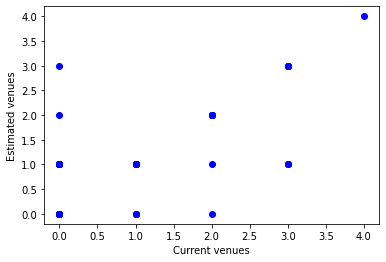

In [40]:
plt.scatter(venue_df.Real, venue_df.Estimation,  color='blue')
plt.xlabel("Current venues")
plt.ylabel("Estimated venues")
plt.show()

Calculating correlation between estimation and real values.

In [41]:
corr = np.corrcoef(venue_df.Real, venue_df.Estimation)

print(corr)

[[1.         0.69027678]
 [0.69027678 1.        ]]


Correlation is between strong (0,8) and moderate (0,6)

Histograms.

(array([35., 35.,  6.,  7.,  1.,  0.]),
 array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5]),
 <a list of 6 Patch objects>)

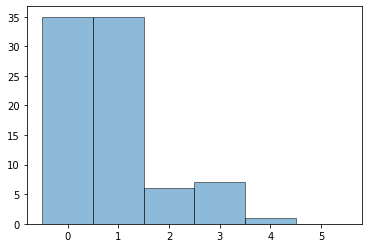

In [53]:
bins_list=[-0.5,0.5,1.5,2.5,3.5,4.5,5.5]
plt.hist(venue_df.Real,edgecolor='black', alpha=0.5, bins=bins_list)

(array([27., 46.,  5.,  5.,  1.,  0.]),
 array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5]),
 <a list of 6 Patch objects>)

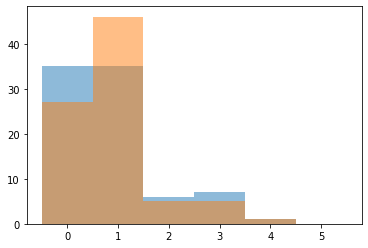

In [52]:
bins_list=[-0.5,0.5,1.5,2.5,3.5,4.5,5.5]
plt.hist(venue_df.Real, alpha=0.5, bins=bins_list)
plt.hist(venue_df.Estimation, alpha=0.5, bins=bins_list)

##3.3. Maps' visualizations

Retrieving Helsinki's location.

In [44]:
address = 'Helsinki, FI'

geolocator = Nominatim(user_agent="fi_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Helsinki are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Helsinki are 60.1674881, 24.9427473.


Mapping existing venues on the map.

In [47]:
# create map of Helsinki using latitude and longitude values
map_helsinki = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label, ammount in zip(venue_df['Latitude'], venue_df['Longitude'], venue_df['current'], venue_df['Real']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=[ammount*5],
        color='Red',
        popup=label,
        fill=False
        ).add_to(map_helsinki)  

map_helsinki 

Visualizing where new venue (and how many) can be established.

In [46]:
# create map of Helsinki using latitude and longitude values
map_helsinki = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label, ammount in zip(venue_df['Latitude'], venue_df['Longitude'], venue_df['estimation'], venue_df['Diff']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=[ammount*5],
        color='Green',
        popup=label,
        fill=False
        ).add_to(map_helsinki)  

map_helsinki  